In [26]:
pip install torchmetrics

In [27]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import os
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.autograd import Variable

from torchmetrics.functional import structural_similarity_index_measure as ssim

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from tqdm import tqdm


In [28]:
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device
device = set_device("cuda")

Cuda installed! Running on GPU 0 Tesla T4!


In [10]:
from google.colab import drive
drive.mount('/content/drive')
file_loc = "/content/drive/MyDrive/Surprise_Storm/tst"

Mounted at /content/drive


In [31]:
def train(model, train_loader, optimizer, loss_fn, epoch, device='cuda'):
    model.train()
    total_loss = 0

    for batch_index, (input_images, target_images) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch} [Training]")):
        #dimension verification to ensure they both have sequence lengths
        assert input_images.ndim == 5, "Input images must be a 5D tensor"
        assert target_images.ndim == 5, "Target images must be a 5D tensor"

        input_images = input_images.to(device)
        target_images = target_images.to(device).squeeze(0)

        optimizer.zero_grad()
        outputs = model(input_images)

        loss = loss_fn(outputs, target_images)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}] - Train Loss: {avg_loss:.4f}")
    return avg_loss


def val(model, test_loader, loss_fn, epoch, device='cuda'):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for input_images, target_images in tqdm(test_loader, desc=f"Epoch {epoch} [Validation]"):
            #dimension verification to ensure batches include a sequence length
            assert input_images.ndim == 5, "Input images must be a 5D tensor"
            assert target_images.ndim == 5, "Target images must be a 5D tensor"

            input_images = input_images.to(device)
            target_images = target_images.to(device).squeeze(0)

            outputs = model(input_images)
            loss = loss_fn(outputs, target_images)

            total_loss += loss.item()

    avg_test_loss = total_loss / len(test_loader)
    print(f"Epoch [{epoch}] - Test Loss: {avg_test_loss:.4f}")
    return avg_test_loss



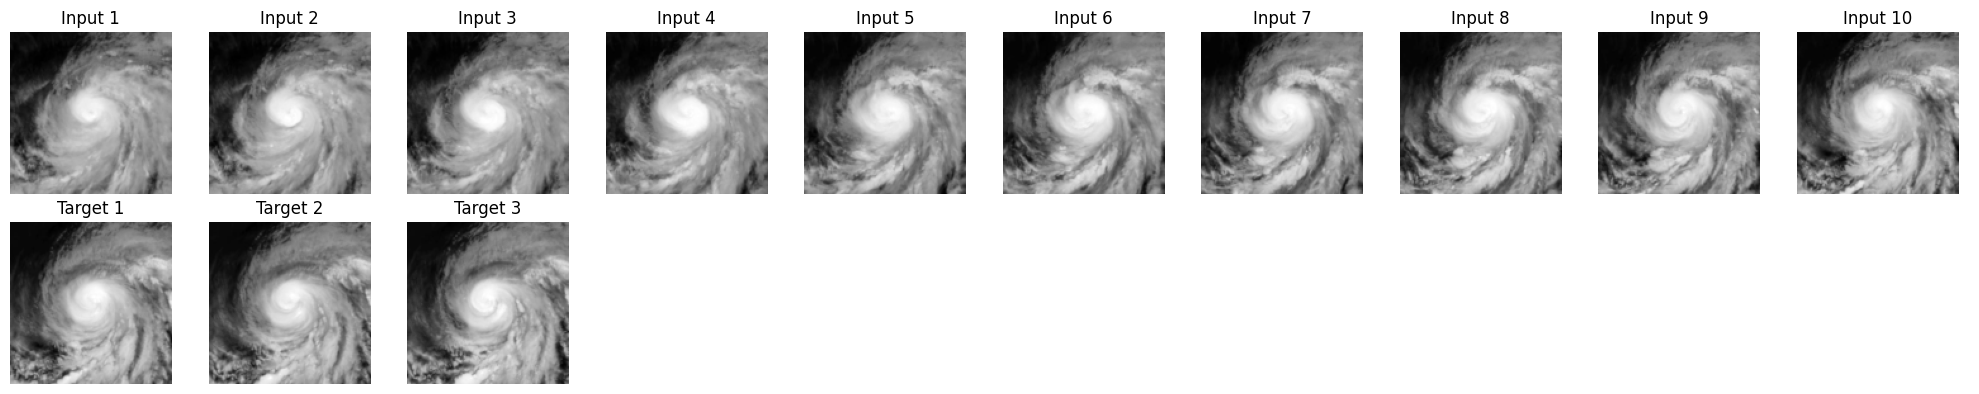

In [32]:
class SequenceImageDataset(Dataset):
    def __init__(self, folder_path, training_length=7, prediction_length=3, transform=None):
        self.folder_path = folder_path
        self.training_length = training_length
        self.prediction_length = prediction_length
        self.sequence_length = training_length + prediction_length
        self.transform = transform

        # List only image files in the folder
        valid_image_extensions = ['.jpg', '.png', '.jpeg']
        self.image_files = [f for f in os.listdir(folder_path)
                            if os.path.isfile(os.path.join(folder_path, f))
                            and os.path.splitext(f)[1].lower() in valid_image_extensions]
        self.image_files.sort()

    def __len__(self):
        return len(self.image_files) - self.sequence_length + 1

    def __getitem__(self, idx):
        sequence_files = self.image_files[idx:idx + self.sequence_length]
        images = [Image.open(os.path.join(self.folder_path, file)).convert('L') for file in sequence_files]
        if self.transform is not None:
            images = [self.transform(image) for image in images]

        input_images = torch.stack(images[:self.training_length])
        target_images = torch.stack(images[self.training_length:])
        return input_images, target_images

# Define transformations for grayscale images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25])
])

# Assuming file_loc is defined and points to your image folder
dataset = SequenceImageDataset(folder_path=file_loc, training_length=10, prediction_length=3, transform=transform)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)  # 80% of the dataset for training
val_size = int(dataset_size * 0.1)  # 10% for validation
test_size = dataset_size - train_size - val_size  # Remaining 10% for testing, to ensure rounding errors don't cause issues

# Split the dataset into training+validation and test datasets first
train_val_dataset, test_dataset = random_split(dataset, [train_size + val_size, test_size])

# Now split the train_val_dataset into training and validation datasets
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])


# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Plotting a batch from the train_loader
dataiter = iter(train_loader)
input_images, target_images = next(dataiter)
input_images = input_images.squeeze(0)  # Remove batch dimension
target_images = target_images.squeeze(0)  # Remove batch dimension

# Number of images in the input and target sequences
num_input_images = input_images.size(0)
num_target_images = target_images.size(0)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=max(num_input_images, num_target_images), figsize=(max(num_input_images, num_target_images) * 2, 4))

# Plot each image in the input sequence
for i in range(num_input_images):
    img = input_images[i].numpy().squeeze()  # Remove color channel dimension
    img = img * 0.25 + 0.5  # Unnormalize the image
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Input {i+1}')
    axes[0, i].axis('off')

# Fill empty subplots in the input row if necessary
for i in range(num_input_images, max(num_input_images, num_target_images)):
    axes[0, i].axis('off')

# Plot each image in the target sequence
for i in range(num_target_images):
    img = target_images[i].numpy().squeeze()  # Remove color channel dimension
    img = img * 0.25 + 0.5  # Unnormalize the image
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'Target {i+1}')
    axes[1, i].axis('off')

# Fill empty subplots in the target row if necessary
for i in range(num_target_images, max(num_input_images, num_target_images)):
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [23]:
print(target_images.size())
print(input_images.size())

torch.Size([3, 1, 128, 128])
torch.Size([10, 1, 128, 128])


In [33]:
class ConvLSTMModel(nn.Module):
    def __init__(self, image_height=128, image_width=128, num_channels=1, num_future_steps=3):
        super(ConvLSTMModel, self).__init__()

        self.num_future_steps = num_future_steps

        # Sequential block for convolution and pooling layers
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the size of the features after the conv and pooling layers
        reduced_height = image_height // (2**3)
        reduced_width = image_width // (2**3)
        self.reduced_size = 64 * reduced_height * reduced_width

        # LSTM layer
        self.lstm = nn.LSTM(input_size=self.reduced_size, hidden_size=1024, num_layers=1, batch_first=True)

        # Fully connected layer for predicting future steps with the number of images to predict
        self.fc = nn.Linear(1024, num_future_steps * num_channels * image_height * image_width)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape
        x = x.view(batch_size * seq_len, C, H, W)

        x = self.conv_block(x)  # Apply convolutional block
        x = x.view(batch_size, seq_len, -1)  # Flatten the features for the LSTM

        # Getting the LSTM outputs for each time step
        lstm_out, _ = self.lstm(x)

        # Predicting future steps from the last LSTM output
        future_images = self.fc(lstm_out[:, -1, :])
        future_images = future_images.view(self.num_future_steps, C, H, W)

        return future_images


In [34]:
# Define SSIM Loss Function
def ssim_loss(preds, target):
    return 1 - ssim(preds, target, data_range=255)

Epoch 1 [Training]: 100%|██████████| 192/192 [00:20<00:00,  9.19it/s]


Epoch [1] - Train Loss: 0.0345


Epoch 1 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 18.07it/s]


Epoch [1] - Test Loss: 0.0257


Epoch 2 [Training]: 100%|██████████| 192/192 [00:20<00:00,  9.40it/s]


Epoch [2] - Train Loss: 0.0192


Epoch 2 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 14.05it/s]


Epoch [2] - Test Loss: 0.0167


Epoch 3 [Training]: 100%|██████████| 192/192 [00:20<00:00,  9.31it/s]


Epoch [3] - Train Loss: 0.0136


Epoch 3 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 17.44it/s]


Epoch [3] - Test Loss: 0.0127


Epoch 4 [Training]: 100%|██████████| 192/192 [00:21<00:00,  8.78it/s]


Epoch [4] - Train Loss: 0.0107


Epoch 4 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 16.94it/s]


Epoch [4] - Test Loss: 0.0104


Epoch 5 [Training]: 100%|██████████| 192/192 [00:21<00:00,  9.05it/s]


Epoch [5] - Train Loss: 0.0088


Epoch 5 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 17.67it/s]


Epoch [5] - Test Loss: 0.0096


Epoch 6 [Training]: 100%|██████████| 192/192 [00:21<00:00,  9.03it/s]


Epoch [6] - Train Loss: 0.0072


Epoch 6 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 12.47it/s]


Epoch [6] - Test Loss: 0.0087


Epoch 7 [Training]: 100%|██████████| 192/192 [00:21<00:00,  8.77it/s]


Epoch [7] - Train Loss: 0.0061


Epoch 7 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 16.67it/s]


Epoch [7] - Test Loss: 0.0078


Epoch 8 [Training]: 100%|██████████| 192/192 [00:20<00:00,  9.18it/s]


Epoch [8] - Train Loss: 0.0053


Epoch 8 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 17.75it/s]


Epoch [8] - Test Loss: 0.0076


Epoch 9 [Training]: 100%|██████████| 192/192 [00:21<00:00,  8.82it/s]


Epoch [9] - Train Loss: 0.0046


Epoch 9 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 17.55it/s]


Epoch [9] - Test Loss: 0.0065


Epoch 10 [Training]: 100%|██████████| 192/192 [00:20<00:00,  9.24it/s]


Epoch [10] - Train Loss: 0.0041


Epoch 10 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 15.05it/s]


Epoch [10] - Test Loss: 0.0066


Epoch 11 [Training]: 100%|██████████| 192/192 [00:20<00:00,  9.22it/s]


Epoch [11] - Train Loss: 0.0035


Epoch 11 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 17.72it/s]


Epoch [11] - Test Loss: 0.0056


Epoch 12 [Training]: 100%|██████████| 192/192 [00:21<00:00,  8.91it/s]


Epoch [12] - Train Loss: 0.0031


Epoch 12 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 17.42it/s]


Epoch [12] - Test Loss: 0.0054


Epoch 13 [Training]: 100%|██████████| 192/192 [00:20<00:00,  9.16it/s]


Epoch [13] - Train Loss: 0.0029


Epoch 13 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 17.56it/s]


Epoch [13] - Test Loss: 0.0052


Epoch 14 [Training]: 100%|██████████| 192/192 [00:21<00:00,  9.00it/s]


Epoch [14] - Train Loss: 0.0026


Epoch 14 [Validation]: 100%|██████████| 24/24 [00:02<00:00, 11.41it/s]


Epoch [14] - Test Loss: 0.0050


Epoch 15 [Training]: 100%|██████████| 192/192 [00:20<00:00,  9.17it/s]


Epoch [15] - Train Loss: 0.0025


Epoch 15 [Validation]: 100%|██████████| 24/24 [00:01<00:00, 17.00it/s]


Epoch [15] - Test Loss: 0.0051


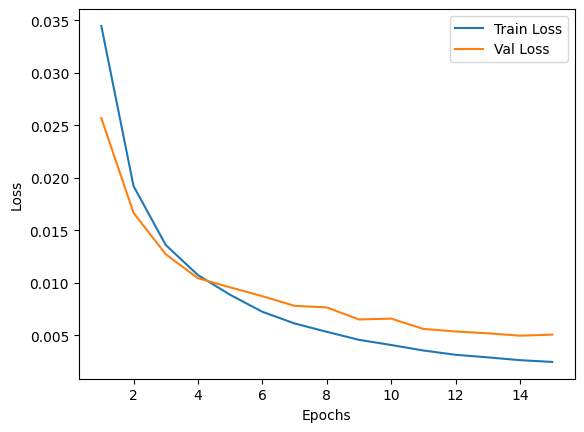

In [39]:
#loss = nn.MSE()
#loss = FSIM_loss

lr = 1e-3
num_epochs = 5
step_size = 5
gamma = 0.85

model = ConvLSTMModel(image_height=128, image_width=128).to(device)
loss = ssim_loss
optimiser = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimiser, step_size=step_size, gamma=gamma)

train_Loss = []
val_Loss = []
epochs = [i for i in range(1, num_epochs + 1)]

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, optimiser, loss, epoch)
    val_loss = val(model, val_loader, loss, epoch)

    train_Loss.append(train_loss)
    val_Loss.append(val_loss)

plt.plot(epochs, train_Loss, label='Train Loss')
plt.plot(epochs, val_Loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.Size([1, 3, 1, 128, 128])
torch.Size([1, 3, 1, 128, 128])


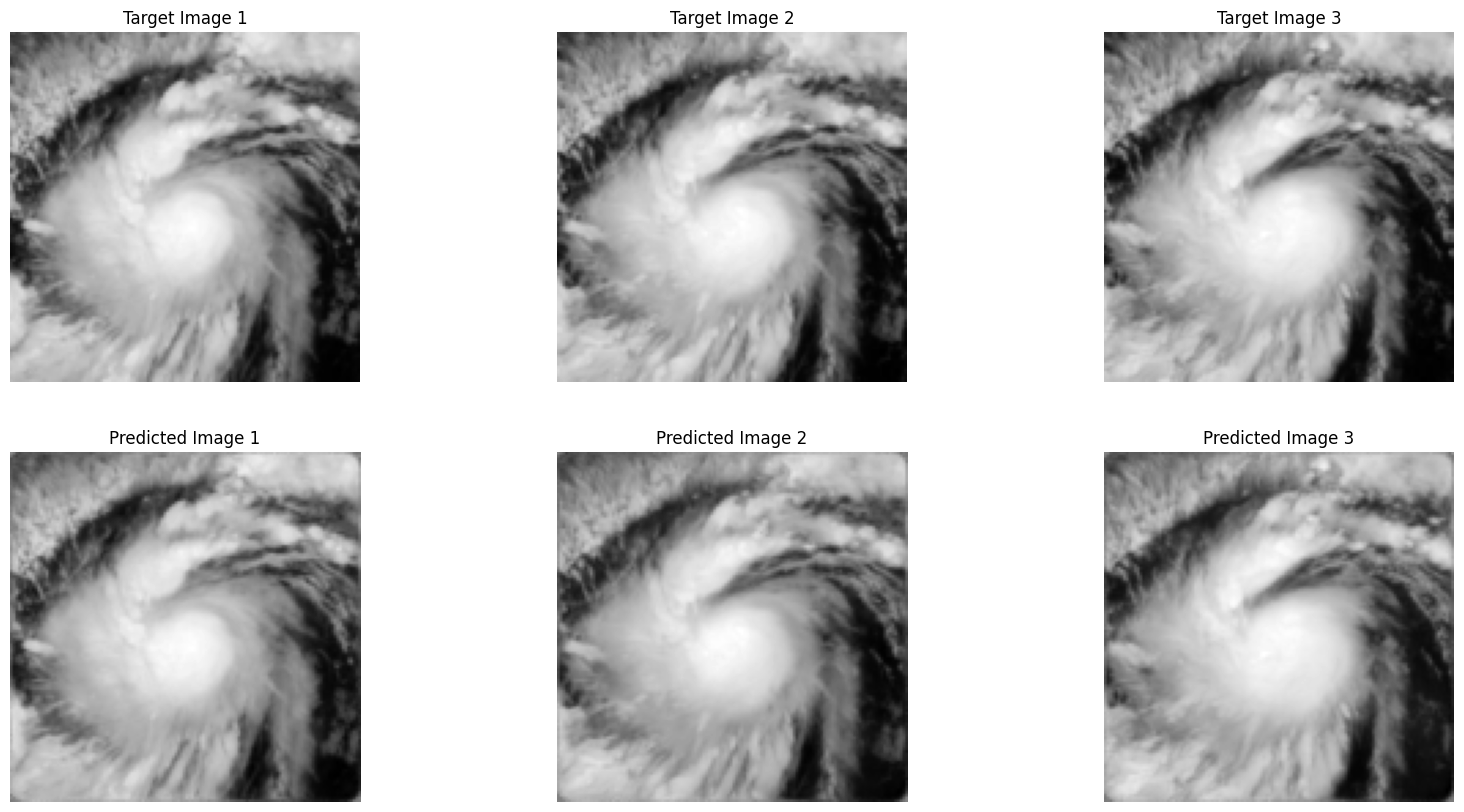

In [26]:
input_images, target_images = next(dataiter)
input_images = input_images.to(device)

# Generate predictions
predicted_images = model(input_images).unsqueeze(0)

print(predicted_images.size())
print(target_images.size())

# Set up subplot grid: 2 rows (target and predicted), 4 columns (input and 3 outputs)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Loop through each of the three target/predicted images
for i in range(3):
    # Display the target images
    target_img = target_images[0, i].cpu().numpy().squeeze()
    axes[0, i].imshow(target_img, cmap='gray')
    axes[0, i].set_title(f'Target Image {i+1}')
    axes[0, i].axis('off')

    # Display the predicted images
    predicted_img = predicted_images[0, i].cpu().detach().numpy().squeeze()
    axes[1, i].imshow(predicted_img, cmap='gray')
    axes[1, i].set_title(f'Predicted Image {i+1}')
    axes[1, i].axis('off')

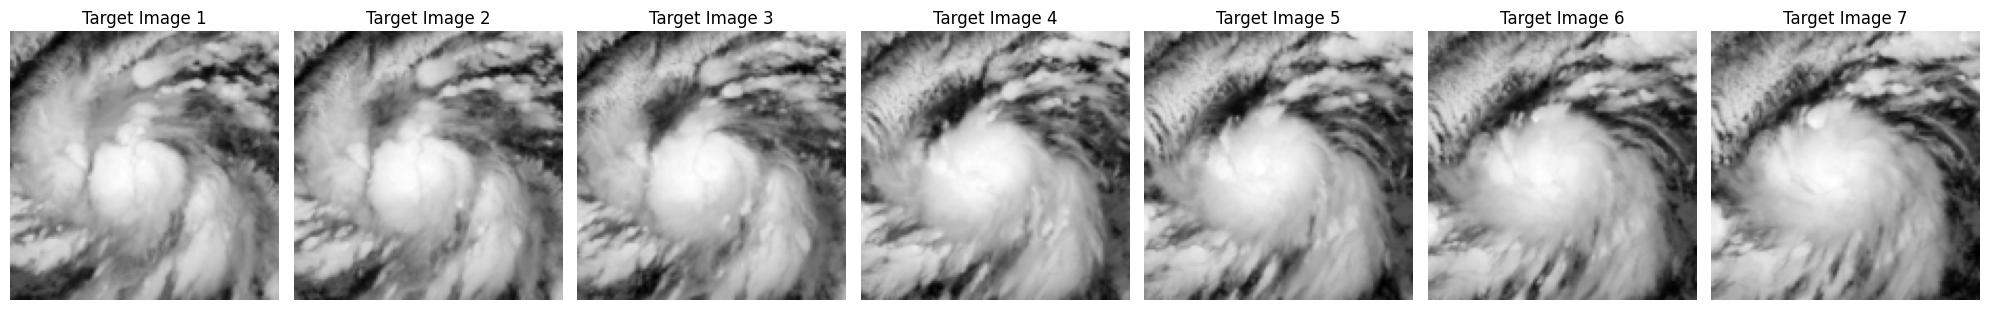

In [28]:
###Figure plote to show previous sequences

fig, axs = plt.subplots(1, 7, figsize=(20, 10))

for i in range(7):
    input_image = input_images[0, i].cpu().numpy().squeeze()
    axs[i].imshow(input_image, cmap='gray')
    axs[i].set_title(f'Target Image {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [27]:
### showing the SSIM metrics of comparison between the predicted and target models

predicted_images = predicted_images.squeeze()
target_images = target_images.squeeze()

for i in range(3):
  predicted = predicted_images[i].unsqueeze(0).unsqueeze(0).to(device)
  target = target_images[i].unsqueeze(0).unsqueeze(0).to(device)
  print(ssim(predicted, target, data_range=1))

tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)


In [29]:
##exporting the weights and biases for the model
torch.save(model.state_dict(), 'CNN_LSTM_tst.pth')